The goal of this notebook is to plot the number of affected "guides" for a set of random NGG sites scattered throughout the genome.

Note: You will need a very big machine with lots of memory to run this.

In [1]:
#Set up the environment
library(tidyverse)
library(reshape2)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [2]:
#Load in Aaron's data
setwd("/home/jupyter/Ancestry/analysis/random_ngg")
random.sites = read.table("final_randoms.txt", sep = "\t", header = T)

In [5]:
head(random.sites)

,seq,chr,posL,posR,CHMI_CHMI3_WGS2,LP6005441.DNA_F08,HGDP00843,HGDP00392,LP6005441.DNA_H03,HGDP00544,⋯,HG00288,HG00290,HG00304,HG01765,HG01766,HG01767,HG01768,HG01785,HG01786,HG02219
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,AAAACGTTTCCAAGACATGATGG,chr22,41636565,41636587,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,AAAAGCCGCATGACCGAGACCGG,chr22,37568153,37568175,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,AAAATACAACTCTGCGACAGAGG,chr22,50739808,50739830,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,AAACACAATCCTCAGAAAGTGGG,chr22,31433897,31433919,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,AAACCAATGTCCCTGGAGTGTGG,chr22,29438936,29438958,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,AAACGGAGCCCACCTCGGCAGGG,chr22,25174323,25174345,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [7]:
#Calculate the number of affected guides in each individual
affected.guides.per.person = random.sites %>%
select(-seq, -chr, -posL, -posR) %>%
apply(2, sum)

In [14]:
#Convert it to a data frame
#Write it, so we don't need to do all of that math again
affected.guides.df = cbind(names(affected.guides.per.person), affected.guides.per.person) %>%
data.frame() %>%
rename("sample" = 1, "num_affected" = 2)

#Now write it
setwd("/home/jupyter/Ancestry/analysis/random_ngg")
write.table(affected.guides.df, "affected_guides_per_gnomad_sample.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

In [15]:
#Read it back in (for downstream analysis and for re-making the figure)
setwd("/home/jupyter/Ancestry/analysis/random_ngg")
affected.guides.df = read.table("affected_guides_per_gnomad_sample.txt", sep = "\t", header = T)

# Create the histogram

In [17]:
#Load in the gnomAD annotation file so that we know which sample belongs to each ancestry group
setwd("/home/jupyter/Ancestry/raw_data/hgdp")
sample.annotation = read.table("gnomad.genomes.v3.1.2.hgdp_1kg_subset_sample_meta.tsv.bgz", sep = "\t", header = T) %>%
select(s, gnomad_population_inference) %>%
mutate(gnomad_population_inference = gsub("\\..*pop", "", gnomad_population_inference)) %>%
mutate(gnomad_population_inference = gsub("prob..*", "", gnomad_population_inference)) %>%
mutate(gnomad_population_inference = gsub("..*:", "", gnomad_population_inference)) %>%
mutate(gnomad_population_inference = gsub(",", "", gnomad_population_inference)) %>%
rename("sample" = 1, "ancestry" = 2)

head(sample.annotation)

,sample,ancestry
,<chr>,<chr>
1,CHMI_CHMI3_WGS2,nfe
2,HG00096,nfe
3,HG00097,nfe
4,HG00099,nfe
5,HG00100,nfe
6,HG00101,nfe


In [22]:
#Calculate the number of guides in the library
tot.guides = nrow(random.sites)
tot.guides

[1] 1000000

In [19]:
#Assemble everything into a single data frame
affected.guides.df = affected.guides.df %>%
rename("sample" = 1, "num_guides" = 2) %>%
inner_join(sample.annotation, by = "sample") %>%
mutate(num_guides = as.numeric(num_guides)) %>%
filter(ancestry != "NA") %>%
mutate(percent_guides = (num_guides/tot.guides)*100)

In [25]:
head(affected.guides.df)

,sample,num_guides,ancestry,percent_guides
,<chr>,<dbl>,<chr>,<dbl>
1,CHMI_CHMI3_WGS2,17505,nfe,1.7505
2,HGDP00843,16180,amr,1.6180
3,HGDP00392,17767,sas,1.7767
4,HGDP00544,18004,oth,1.8004
5,HGDP01053,16498,amr,1.6498
6,HGDP00191,17306,sas,1.7306


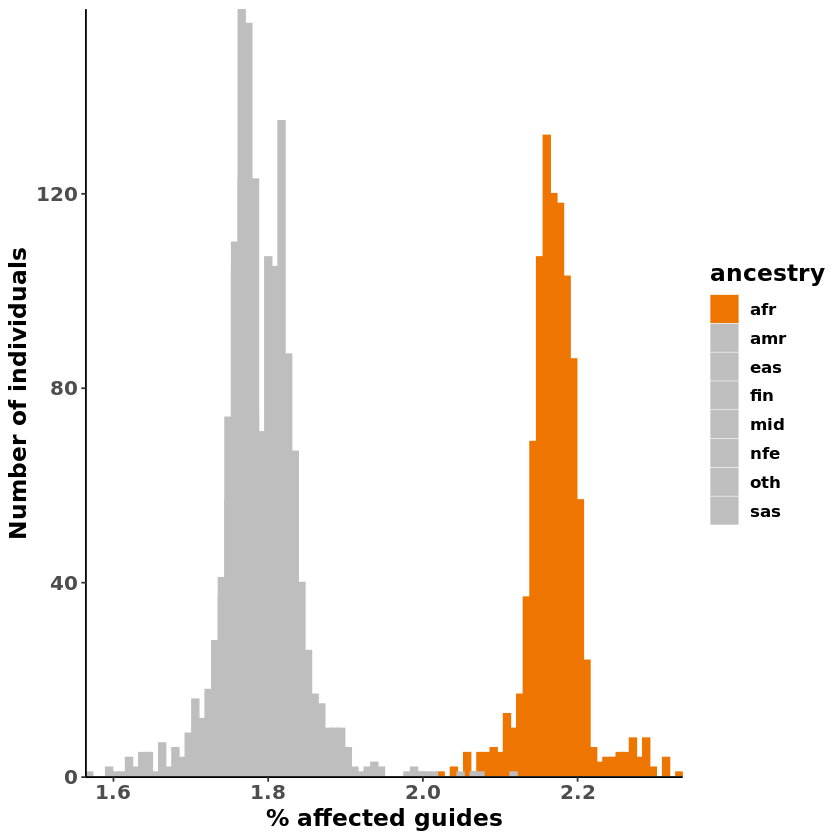

In [24]:
#Plot the data
affected.guides.df %>%
ggplot() +
geom_histogram(aes(x = percent_guides, color = ancestry, fill = ancestry), bins = 90, position="identity") +
theme_bw() +

scale_color_manual(values=c("darkorange2", "grey", "grey", "grey", "grey", "grey", "grey", "grey")) +
scale_fill_manual(values=c("darkorange2", "grey", "grey", "grey", "grey", "grey", "grey", "grey")) +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +

scale_y_continuous(expand = c(0,0)) +
scale_x_continuous(expand = c(0,0)) +

ylab("Number of individuals") +
xlab("% affected guides")


setwd("/home/jupyter/Ancestry/analysis/random_ngg")
ggsave("affected_guides_per_individual_random_ngg.pdf", width = 5, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/random_ngg
gsutil cp affected_guides_per_individual_random_ngg.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

# Do some calculations for the manuscript text

Calculate how many guides are affected in at least one individual

In [29]:
#Calculate the sum of samples affected per guide
affected.samples.per.guide = random.sites %>%
select(-seq, -chr, -posL, -posR) %>%
apply(1, sum)

[1] 623174

In [30]:
#How many guides are affected in at least one sample?
num.affected.guides = affected.samples.per.guide[affected.samples.per.guide >= 1] %>% length()
num.affected.guides

#what percent of guides are affected
percent.affected.guides = (num.affected.guides/nrow(random.sites))*100
percent.affected.guides


[1] 623174

[1] 62.3174

In [34]:
#How many guides are affected in each individual?
median.affected.all.groups = affected.guides.df %>%
pull(percent_guides) %>%
median()

#in afr indivuals?
median.affected.afr = affected.guides.df %>%
filter(ancestry %in% "afr") %>%
pull(percent_guides) %>%
median()

#in non-afr individuals?
median.affected.non.afr = affected.guides.df %>%
filter(ancestry != "afr") %>%
pull(percent_guides) %>%
median()



median.affected.all.groups
median.affected.afr
median.affected.non.afr

[1] 1.7967

[1] 2.16995

[1] 1.7805

In [31]:
head(affected.guides.df)

,sample,num_guides,ancestry,percent_guides
,<chr>,<dbl>,<chr>,<dbl>
1,CHMI_CHMI3_WGS2,17505,nfe,1.7505
2,HGDP00843,16180,amr,1.6180
3,HGDP00392,17767,sas,1.7767
4,HGDP00544,18004,oth,1.8004
5,HGDP01053,16498,amr,1.6498
6,HGDP00191,17306,sas,1.7306
